# Process Data using MediaPipe Pose Extraction

This contains our code to extract the WLASL100 and process the videos into numpy arrays and glosses into integer labels

References:
* https://www.kaggle.com/code/abd0kamel/mutemotion-wlasl-translation-model
* https://openaccess.thecvf.com/content/WACV2022W/HADCV/papers/Bohacek_Sign_Pose-Based_Transformer_for_Word-Level_Sign_Language_Recognition_WACVW_2022_paper.pdf

## Import and Install Libraries

* Import Mediapipe for landmark extraction
* Define global variables

In [1]:
%pip install -q mediapipe==0.10.7

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

In [3]:
'''
Modify variables for respective computer
Rena: 'wlasl'
Esther: '/Users/esther/Downloads/archive'
'''
base_path = 'wlasl'


'''
n determines number of glosses we wish to extract
'''
n = 100

'''
Modify directory where top 100 glosses are
'''
video_dir = f'{base_path}/videos{n}'

## Define landmark extraction functions

We use Mediapipe to extract the following landmarks:
* Hands: 42 (21 per hand)
* Pose: 7 for the face (eyes, nose, ends of mouth), 4 for the upper body (shoulders, elbows)

We only extract (x,y) coordinates and disregard the z coordinate

Total: 53 landmarks each with coordinates (x,y) = 106 features per frame

In [4]:
# import enumerated types of the landmarks
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.hands import HandLandmark

In [5]:
# import enumerated types of the landmarks
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.hands import HandLandmark

# define which landmarks from pose we want to keep
filtered_pose = [
  PoseLandmark.NOSE,
  PoseLandmark.LEFT_EYE_INNER,
  PoseLandmark.RIGHT_EYE_INNER,
  PoseLandmark.LEFT_EYE_OUTER,
  PoseLandmark.RIGHT_EYE_OUTER,
  PoseLandmark.MOUTH_LEFT,
  PoseLandmark.MOUTH_RIGHT,
  PoseLandmark.LEFT_SHOULDER,
  PoseLandmark.RIGHT_SHOULDER,
  PoseLandmark.LEFT_WRIST,
  PoseLandmark.RIGHT_WRIST,
  PoseLandmark.LEFT_ELBOW,
  PoseLandmark.RIGHT_ELBOW,
]

HAND_NUM = len(HandLandmark) # we use all hand landmarks
POSE_NUM = len(filtered_pose)

print(f'total landmarks = {2 * HAND_NUM + POSE_NUM}')

total landmarks = 55


In [6]:
# Initialize MediaPipe Models
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face = mp.solutions.face_detection.FaceDetection()

'''
A function to exract the hands, and pose landmarks given a single frame
Params:
    frame: a (image height, image width, (R,G,B) channel values) shape numpy array 
    representing an image in RGB colors
Returns:
    a (2 * NAND_NUM + POSE_NUM, (x,y) coordinates) numpy array containing the relevant
    landmarks of the frame
'''
# For a given (single) frame, extract hands, pose, and face landmarks
def get_frame_landmarks(frame):
    
    # Initialize array to store x,y coordinates of the detected landmarks (hands and pose)
    all_landmarks = np.zeros((2 * HAND_NUM + POSE_NUM, 2))
    
    def get_hands(frame):
        # Applies hand detection and landmark estimation model to the frame and returns the results
        # Result includes detected hand landmarks
        results_hands = hands.process(frame)
        # Checks if any hand landmarks were detected in the frame
        if results_hands.multi_hand_landmarks:
            # If the list is not empty
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                # Checks if the current hand being processed is classified as right hand
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    # Updates first 'HAND_NUM' rows of all_landmarks array with x,y coordinates of detected right hand landmarks
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y) for lm in hand_landmarks.landmark])
                else:
                    # Repeat for left hand
                    all_landmarks[HAND_NUM:2*HAND_NUM, :] = np.array(
                        [(lm.x, lm.y) for lm in hand_landmarks.landmark]) # left
    
    # Get the landmarks for the upper body and store in the array
    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[2*HAND_NUM:2*HAND_NUM+POSE_NUM, :] = np.array(
                [(lm.x, lm.y) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
    
    def get_face(frame):
        results_face = face.process(frame)
        if results_face.detections:
            all_landmarks[2*HAND_NUM+POSE_NUM:, :] = np.array(
                [(lm.x, lm.y) for lm in results_face.detections])
            print(results_face.detections)
    
    # ThreadPoolExecutor implemented to run the modules in parallel
    # Improve efficiency of processing video frames
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        #executor.submit(get_face, frame)

    return all_landmarks

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
'''
A function to get the landmarks for all frames in a video
Params:
    video_path: a string of the stored path of the video
    start_frame: an int representing the first frame of video where the signing starts
    end_frame: an int representing the last frame of the video where the signing ends
Returns:
    a (end_frame-start_frame+1, 2 * NAND_NUM + POSE_NUM, (x,y) coordinates) numpy array
    containing the relevant landmarks of each frame in a video
'''
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    
    # If the starting is 0
    if start_frame <= 1:
        start_frame = 1
        
    # If the video is precropped - adjust start and end to include the entire video
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    # If the final frame was not given (-1) - set to total number of frames in the video
    if end_frame < 0: 
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize array to store landmakrs for all frames
    num_landmarks = HAND_NUM * 2 + POSE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 2))
    frame_index = 1
    
    # Check if video capture object is stil valid and frame is within the desired range
    while cap.isOpened() and frame_index <= end_frame:
        # Read next frame from the video
        # ret - boolean to indicate if the frame was successfully read
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            # Make the frame read-only - optimize process
            frame.flags.writeable = False
            # Convert frame from BGR color format to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Extract landmakrs from current frame
            frame_landmarks = get_frame_landmarks(frame)
            # Store all the landmarks in the array
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    # Release video capture object
    cap.release()
    # Rest MediaPipe models to initial state - clear stored state or information
    hands.reset()
    pose.reset()
    face.reset()
    
    return all_frame_landmarks

### Visualize landmarks on an example image
Iterate through the landmarks of each frame in the video and rewrites the frame with marked landmarks

Outputs the new frames as a video (sequence of the frames)

In [35]:
'''
A function to draw the landmarks on an image
Params:
    input_path: a string of the path of the image to draw landmarks on
    output_path: a string of the path to write the image with landmarks on it
    video_landmarks: a (frames, 2 * NAND_NUM + POSE_NUM, (x,y) coordinates) numpy array containing the
        landmarks of the videos
    start_frame: an int representing the first frame of video where the signing starts
    end_frame: an int representing the last frame of the video where the signing ends
Returns:
    None
'''
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    # Set up video capture object to read from input path and video write object to write processed frames to output path
    # Frame rate, width, height of output videos are matched to input video's properties
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Adjust starting and ending frame
    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_index >= start_frame and frame_index <= end_frame:
            # Extract the landmarks for current frame and scale the coordinates to match the frame's dimensions
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y in frame_landmarks]
            # For each landmark, circle is drawn on the frame
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            # Processed frame with landmarks written to output file
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

### Example visualization of extracting landmarks

Use an image online to test
* get_frame_landmarks
* get_video_landmarks
* draw_landmarks

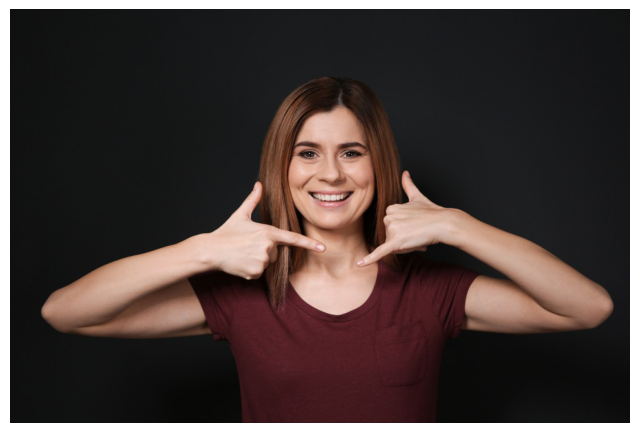

In [9]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://www.memorialhearing.com/wp-content/uploads/2021/11/The-Role-of-Sign-Language-Interpreters-Memorial-Hearing-1.jpg'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

[0.68821883 0.66048688]
688.2188320159912 440.5447469353676
[0.37031579 0.67059147]
370.3157901763916 447.2845128774643


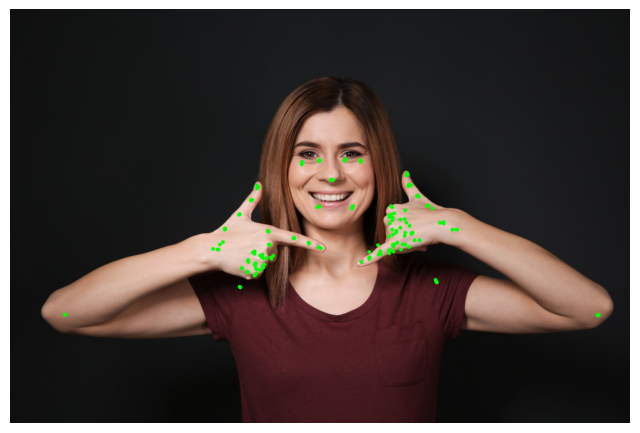

In [13]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])

for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

print(frame_landmarks[49])
print(frame_landmarks[49][0]*width,frame_landmarks[49][1]*height)
print(frame_landmarks[50])
print(frame_landmarks[50][0]*width,frame_landmarks[50][1]*height)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

## Data Encoding (done once!)

For each video, find the video landmarks and save as a numpy file

Then, use each numpy file to create a landmarks numpy array of all data (download link provided at end)

### Define and save landmarks for all videos
* Save a landmark numpy for each video in videos100
* Combine landmarks of each video into a dictionary 

In [7]:
# parse the JSON data and convert to Python data structure (list or dictionary)
with open(f'{base_path}/WLASL{n}_parsed_data.json', 'r') as json_file:
    data100 = json.load(json_file)

len(data100)

2038

In [8]:
lmark_dir = f'{base_path}/landmarks100'
os.makedirs(lmark_dir, exist_ok=True)

In [19]:
# For each video, its landmarks are extracted and stored in a .npy file
try:
    for i in tqdm(range(len(data100)), ncols=100):
        video_id = data100[i]['video_id']
        npy_path = os.path.join(lmark_dir, f'{video_id}.npy')
        if os.path.exists(npy_path): continue
        video_path = data100[i]['video_path']
        start = data100[i]['frame_start']
        end = data100[i]['frame_end']
        
        try:
            video_landmarks = get_video_landmarks(video_path, start, end)
            np.save(npy_path, video_landmarks)
            
        except Exception as e:
            print(f"\nError encoding {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

100%|███████████████████████████████████████████████████████████| 2038/2038 [56:27<00:00,  1.66s/it]


In [23]:
lmarks100_dict = {}

for filename in os.listdir(lmark_dir):
    if filename.endswith('.npy'):
        key = filename.split('.')[0]
        landmarks = np.load(os.path.join(lmark_dir, filename), allow_pickle=True)
        shape = landmarks.shape
        landmarks_reshaped = (landmarks.reshape((shape[0], shape[1] * shape[2]))).T
        lmarks100_dict[key] = landmarks_reshaped # (landmarks=55 * (x,y) coordinates, frames)

np.savez(f'{base_path}/landmarks100.npz', **lmarks100_dict)

FileLink(rf'{base_path}/landmarks100.npz')

/Users/renabi/Academia/2024 Spring/Computer Vision/asl-recognition/wlasl/landmarks100.npz

### Example Video Landmarking

In [22]:
vid_index = 2000
vid_inst = data100[vid_index]
vid_id = vid_inst['video_id']

video_landmarks = get_video_landmarks(vid_inst['video_path'],vid_inst['frame_start'],vid_inst['frame_end'])

print(np.shape(video_landmarks))

output_path = f'{base_path}/landmarks_{vid_id}.mp4'
draw_landmarks(vid_inst['video_path'], output_path, video_landmarks, vid_inst['frame_start'],vid_inst['frame_end'])
print(output_path)

(40, 55, 2)
wlasl/landmarks_53270.mp4


### Write Data

* Load in relevant parsed data from video preprocess ipynb
  * Landmarks: the landmarks for each video
  * Data: metadata of video instances (WLASL100 in this case for videos of top 100 glosses)
* Split data into train, test, and val sets

In [8]:
lmarks100_dict = np.load(f'{base_path}/landmarks100.npz', allow_pickle=True)

with open(f'{base_path}/WLASL100_parsed_data.json', 'r') as json_file:
    data100 = json.load(json_file)

print(len(lmarks100_dict))
print(len(data100))


2038
2038


In [9]:
data100[4] # the metadata for one video instance

{'gloss': 'book',
 'label': 0,
 'bbox': [95, 0, 1180, 720],
 'video_id': '68012',
 'video_path': 'wlasl/videos100/68012.mp4',
 'frame_start': 1,
 'frame_end': -1,
 'split': 'train'}

In [10]:
print(np.shape(lmarks100_dict['68012'])) # (landmarks=55 * (x,y) coordinates, frames)

(110, 96)


In [11]:
'''
A function to load in the data into a split
Params:
  split: a string representing 'train', 'test', or 'val' corresponding to the set
  labels_dict: a dictionary of labels to integers representing a gloss and its numerical class
  landmarks_dict: a dictionary of string keys to a numpy array representing a video instance and its landmarks
Returns:
  a (# videos, # frames, 55 landmarks, (x,y) coordinates) numpy array of the landmarks for each video
  a (# videos,) numpy array of integers representing the class of each video
'''

def load_data(split=None, data=None, lmarks_dict=lmarks100_dict):

  keys = [data[i]['video_id'] for i in range(len(data))]
  if split is not None:
    X = [lmarks_dict[keys[i]][:, :].tolist() for i in range(len(data)) if data[i]['split'] == split]
    Y = [data[i]['label'] for i in range(len(data)) if data[i]['split'] == split]
  else:
    X = [lmarks_dict[keys[i]][:, :].tolist() for i in range(len(data))]
    Y = [data[i]['label'] for i in range(len(data))]

  return X, Y

In [12]:
# Creating the training, testing, validation dataset
X_train, Y_train = load_data('train', data100)
X_val, Y_val = load_data('val', data100)
X_test, Y_test = load_data('test', data100)

In [13]:
print("# videos in train set: ", len(X_train))
print("# videos in test set: ", len(X_test))
print("# videos in val set: ", len(X_val))

# videos in train set:  1442
# videos in test set:  258
# videos in val set:  338


In [27]:
instance = 1 # video instance index

print(len(X_train[instance])) # number features (55*2 landmarks)
print(len(X_train[instance][0])) # number frames for feature 0
print(len(X_train[instance][1])) # number frames for feature 1
print(type(X_train[instance][1])) 
print(type(X_train[instance][1][0])) 

110
64
64
<class 'list'>
<class 'float'>


In [28]:
print("# unique labels in train set: ", len(np.unique(Y_train)))
print("# unique labels in test set: ", len(np.unique(Y_test)))
print("# unique labels in val set: ", len(np.unique(Y_val)))

# unique labels in train set:  100
# unique labels in test set:  100
# unique labels in val set:  100


### Write Data to File For Future Models

* Want to define train, test, val sets that are of shape (videos, 55*2 + 1, frames)
  * 55*2 for landmarks, 1 for the label

In [14]:
# import the names of the landmarks
lmark_names = {}
with open(f'{base_path}/mpipe_lmarks.txt', 'r') as file:
    for line in file:
        # Split each line into key and value parts
        key, value = line.strip().split(': ')
        # Add key-value pair to dictionary
        lmark_names[int(key)] = value

len(lmark_names)

110

In [15]:
import csv

'''
A function to write provided X and Y arrays and header names to a csv file of (rows, columns)
Params:
  path: a str representing the path to write the file to
  X: a (rows, columns-1) shape list
  Y: a (rows) shape list
  X_head: a (columns-1) shape list of str
  Y_head: a str of of the name of the Y values
'''
def write_data(path, X, Y, X_head, Y_head):
  assert len(X) == len(Y), 'write error: X and Y are not equal length'
  with open(f'{path}', 'w') as file:
    writer = csv.writer(file)
    header = X_head + [Y_head]
    writer.writerow(header)
    for (x,y) in zip(X,Y):
      writer.writerow(x + [y])


In [16]:
X_head = list(lmark_names.values())
Y_head = 'label'

In [17]:
write_data(f'{base_path}/train.csv', X_train, Y_train, X_head, Y_head)
write_data(f'{base_path}/test.csv', X_test, Y_test, X_head, Y_head)
write_data(f'{base_path}/val.csv', X_val, Y_val, X_head, Y_head)


In [33]:
import pandas as pd

df = pd.read_csv(f'{base_path}/train.csv')
df

,wristR_X,wristR_Y,thumb_cmcR_X,thumb_cmcR_Y,thumb_mcpR_X,thumb_mcpR_Y,thumb_ipR_X,thumb_ipR_Y,thumb_tipR_X,thumb_tipR_Y,...,shoulderR_Y,wposeL_X,wposeL_Y,wposeR_X,wposeR_Y,elbowL_X,elbowL_Y,elbowR_X,elbowR_Y,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3477651774883...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8292424678802...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3873025476932...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8104795813560...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4266096651554...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8273414969444...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4527616202831...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8545405268669...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4734343290328...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8752900958061...",...,"[0.5151205658912659, 0.4924091398715973, 0.488...","[0.6703683137893677, 0.6186122298240662, 0.609...","[0.9419851303100586, 0.9600414037704468, 0.955...","[0.3902769088745117, 0.3859167695045471, 0.416...","[0.9027020335197449, 0.905351459980011, 0.9377...","[0.74842768907547, 0.7230930328369141, 0.71842...","[0.7894797325134277, 0.7811499238014221, 0.768...","[0.29708388447761536, 0.27849453687667847, 0.2...","[0.7566343545913696, 0.7608867287635803, 0.760...",0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.4935420751571655, 0.5011000633239746, 0.504...","[0.7099831104278564, 0.6985950469970703, 0.693...","[0.9576476216316223, 0.9827195405960083, 0.994...","[0.3130965828895569, 0.3228655457496643, 0.328...","[0.9472627639770508, 0.9600162506103516, 0.967...","[0.7138449549674988, 0.714741587638855, 0.7152...","[0.7515889406204224, 0.779191792011261, 0.7897...","[0.28198885917663574, 0.28218355774879456, 0.2...","[0.7654576301574707, 0.7779296636581421, 0.782...",0
2,"[0.4065203368663788, 0.0, 0.0, 0.4262121319770...","[0.7847134470939636, 0.0, 0.0, 0.6645262241363...","[0.42358261346817017, 0.0, 0.0, 0.449526846408...","[0.754591166973114, 0.0, 0.0, 0.64803087711334...","[0.4428410530090332, 0.0, 0.0, 0.4590576887130...","[0.7264677882194519, 0.0, 0.0, 0.6104863882064...","[0.4543265402317047, 0.0, 0.0, 0.4640135169029...","[0.7031329274177551, 0.0, 0.0, 0.5849741697311...","[0.4601845443248749, 0.0, 0.0, 0.4671737849712...","[0.6833667755126953, 0.0, 0.0, 0.5659558773040...",...,"[0.5005713701248169, 0.4999662935733795, 0.500...","[0.6039326786994934, 0.6095348596572876, 0.605...","[0.7769789695739746, 0.7636581659317017, 0.732...","[0.39559417963027954, 0.39556118845939636, 0.3...","[0.8018900156021118, 0.764588475227356, 0.7058...","[0.7483040690422058, 0.7490140199661255, 0.749...","[0.7569034695625305, 0.757196307182312, 0.7574...","[0.26620614528656006, 0.266861230134964, 0.266...","[0.8027722835540771, 0.7966734766960144, 0.796...",0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.5647964477539062, 0.5656047463417053, 0.566...","[0.7220399975776672, 0.7229859828948975, 0.726...","[1.02046537399292, 1.052573800086975, 1.064112...","[0.33175522089004517, 0.30680593848228455, 0.3...","[1.0045692920684814, 1.0181362628936768, 1.026...","[0.7747090

In [35]:
df.columns.tolist()

['wristR_X',
 'wristR_Y',
 'thumb_cmcR_X',
 'thumb_cmcR_Y',
 'thumb_mcpR_X',
 'thumb_mcpR_Y',
 'thumb_ipR_X',
 'thumb_ipR_Y',
 'thumb_tipR_X',
 'thumb_tipR_Y',
 'index_mcpR_X',
 'index_mcpR_Y',
 'index_pipR_X',
 'index_pipR_Y',
 'index_dipR_X',
 'index_dipR_Y',
 'index_tipR_X',
 'index_tipR_Y',
 'middle_mcpR_X',
 'middle_mcpR_Y',
 'middle_pipR_X',
 'middle_pipR_Y',
 'middle_dipR_X',
 'middle_dipR_Y',
 'middle_tipR_X',
 'middle_tipR_Y',
 'ring_mcpR_X',
 'ring_mcpR_Y',
 'ring_pipR_X',
 'ring_pipR_Y',
 'ring_dipR_X',
 'ring_dipR_Y',
 'ring_tipR_X',
 'ring_tipR_Y',
 'pinky_mcpR_X',
 'pinky_mcpR_Y',
 'pinky_pipR_X',
 'pinky_pipR_Y',
 'pinky_dipR_X',
 'pinky_dipR_Y',
 'pinky_tipR_X',
 'pinky_tipR_Y',
 'wristL_X',
 'wristL_Y',
 'thumb_cmcL_X',
 'thumb_cmcL_Y',
 'thumb_mcpL_X',
 'thumb_mcpL_Y',
 'thumb_ipL_X',
 'thumb_ipL_Y',
 'thumb_tipL_X',
 'thumb_tipL_Y',
 'index_mcpL_X',
 'index_mcpL_Y',
 'index_pipL_X',
 'index_pipL_Y',
 'index_dipL_X',
 'index_dipL_Y',
 'index_tipL_X',
 'index_tipL_Y',


### Analyze 3rd dimension (# of frames)
* Each video has different number of frames, i.e. the shape of X below is (2038, 110, frames) where frames is different

In [72]:
X, Y = load_data(data=data100)

In [15]:
print(len(X), len(Y))

2038 2038


In [18]:
print(len(X[0][0]), len(X[1][0]), len(X[2][0]), len(X[3][0])) # frames dimension is different for each video instance

64 64 47 60


In [24]:
max_length = 0
max_index = None

for i in range(len(X)):
    for j in range(len(X[i])):
        if len(X[i][j]) > max_length:
            max_length = len(X[i][j])
            max_index = (i, j)

print("Maximum length:", max_length)
print("Index of maximum length:", max_index)


Maximum length: 203
Index of maximum length: (691, 0)


In [76]:
frames = []
vid_index = 0
max_len = -1
for i, inst in enumerate(X):
  frames.append(len(inst[0]))
  if (len(inst[0]) > max_len):
    max_len = len(inst[0])
    vid_index = i

print(len(frames), max_len, sum(frames), sum(frames)/len(frames))
print(vid_index)


2038 203 125855 61.75417075564279
691


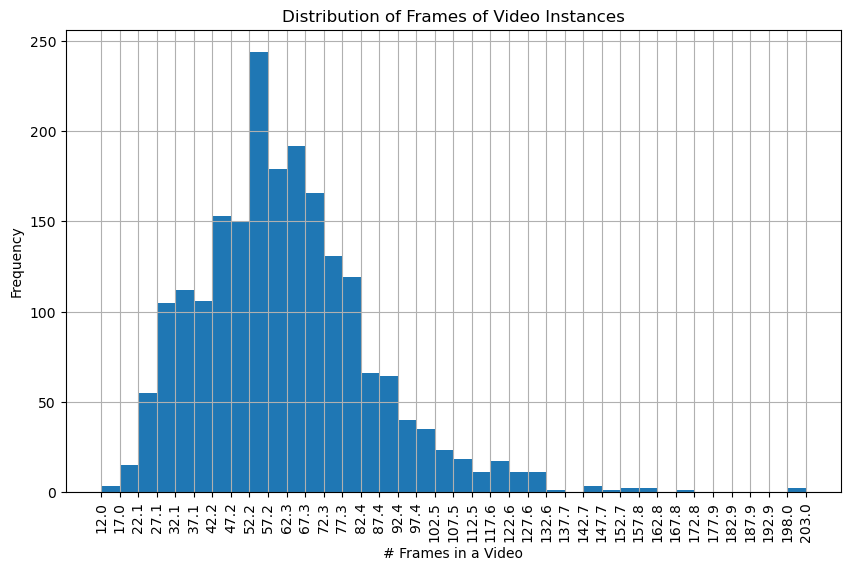

In [69]:
min_val = min(frames)
max_val = max(frames)
bin_size = 5  
num_bins = int((max_val - min_val) / bin_size)

plt.figure(figsize=(10, 6))
plt.hist(frames, bins=num_bins)  # Adjust the number of bins as needed
plt.title('Distribution of Frames of Video Instances')
plt.xlabel('# Frames in a Video')
plt.ylabel('Frequency')
plt.grid(True)

bin_edges = np.linspace(min_val, max_val, num_bins + 1)
plt.xticks(bin_edges, rotation='vertical')

plt.show()
# diff_frames = [len(frames) for inst in X for frames in inst[0]]

In [78]:
vid_inst = data100[vid_index]
vid_id = vid_inst['video_id']

video_landmarks = get_video_landmarks(vid_inst['video_path'],vid_inst['frame_start'],vid_inst['frame_end'])

print(np.shape(video_landmarks))

output_path = f'{base_path}/landmarks_{vid_id}.mp4'
draw_landmarks(vid_inst['video_path'], output_path, video_landmarks, vid_inst['frame_start'],vid_inst['frame_end'])
print(output_path)

(203, 55, 2)
wlasl/landmarks_57628.mp4
